In [58]:
import numpy as np
import matplotlib.pyplot as plt
from parse import parse
import math
import time
import cv2

In [15]:
train_images, train_labels = parse('facedata/facedatatrain', 'facedata/facedatatrainlabels', True)
validation_images, validation_labels = parse('facedata/facedatavalidation', 'facedata/facedatavalidationlabels', True)
test_images, test_labels = parse('facedata/facedatatest', 'facedata/facedatatestlabels', True)


In [16]:
base_rate_true = np.bincount(train_labels)/train_labels.shape[0]
print(base_rate_true)

[0.51884701 0.48115299]


In [17]:
kernel = np.ones((7,3))
images = np.swapaxes(np.swapaxes(train_images.astype(np.float64), 0, 2), 0, 1)
dst = cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))
train_zones = dst[::7,::3,:]

vimages = np.swapaxes(np.swapaxes(validation_images.astype(np.float64), 0, 2), 0, 1)
vdst = cv2.filter2D(src = vimages, ddepth = -1, kernel = kernel, anchor = (0,0))
vzones = vdst[::7,::3,:]


timages = np.swapaxes(np.swapaxes(test_images.astype(np.float64), 0, 2), 0, 1)
tdst = cv2.filter2D(src = timages, ddepth = -1, kernel = kernel, anchor = (0,0))
test_zones = tdst[::7,::3,:]

In [18]:
def train_perceptron_faces(passes, labels, zones):
    weights = np.zeros(200)
    bias = 0
    for k in range(passes):
        for i in range(len(labels)):
            arr = zones[:,:,i].ravel()
            b = np.dot(weights, arr) +bias
            if b < 0 and labels[i] == True:
                weights += arr
                bias += 1
            elif b >= 0 and labels[i] == False:
                weights -= arr
                bias -= 1
    return weights, bias


In [19]:
def run_perceptron_faces(weights, labels, zones, bias):
    tally = 0
    for i in range(len(labels)):
        arr = zones[:,:,i].ravel()
        b = np.dot(weights, arr) + bias 
        if (b >= 0 and labels[i] == True) or (b < 0 and labels[i] == False):
            tally += 1
    return (tally/len(labels))


In [36]:
w, b = train_perceptron_faces(2000, train_labels, train_zones)

run_perceptron_faces(w, validation_labels, vzones, b)

0.9003322259136213

In [70]:
def run_percentage(zones, labels, tzones, tlabels, iters):
    mean_acc = np.zeros(10)
    std = np.zeros(10)
    mean_runtime = np.zeros(10)
    for i in range(1,11):
        accuracy = np.zeros(iters, dtype=np.float64)
        runtime = np.zeros(iters, dtype=np.float64)
        for j in range(iters):
            start_time = time.time()
            amount = int(0.1 * i * len(zones[0][0]))
            available_indices = np.random.choice(len(zones[0][0]), amount, replace = False)
            available_zones = zones[:,:,available_indices]
            available_labels= labels[available_indices]
            w, b = train_perceptron_faces(200, available_labels, available_zones)
            accuracy[j-1] = run_perceptron_faces(w, tlabels, tzones, b)
            runtime[j-1] = time.time()-start_time
        mean_acc[i-1] = np.mean(accuracy)
        std[i-1] = np.std(accuracy)
        mean_runtime[i-1] = np.mean(runtime)
    return mean_acc, std, mean_runtime

[0.75583333 0.84       0.8275     0.86       0.87416667 0.87583333
 0.88833333 0.8825     0.88666667 0.88916667] [0.04932179 0.02       0.03627633 0.03464102 0.02093309 0.01450575
 0.01624466 0.01411756 0.01333333 0.01050793] [0.02802995 0.05446774 0.08240652 0.10974279 0.13826004 0.16129732
 0.19120434 0.2186321  0.24494305 0.27042449]


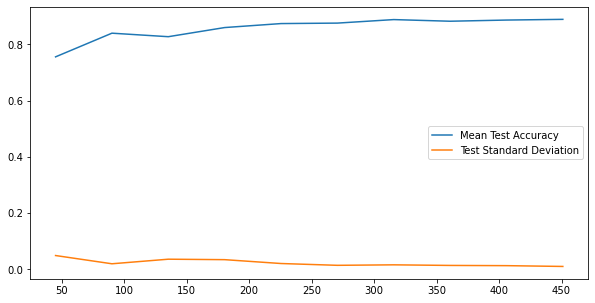

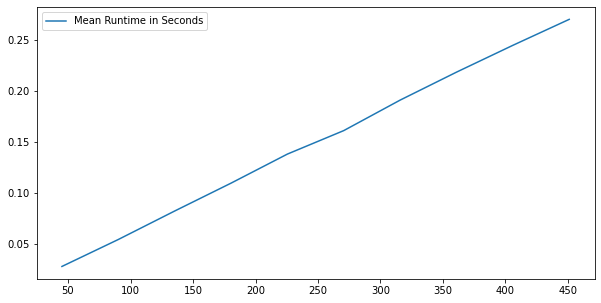

In [71]:
x = np.linspace(.1*train_images.shape[0], train_images.shape[0], 10)
acc, std, runtime= run_percentage(train_zones, train_labels, test_zones, test_labels, 8)
print(acc, std, runtime)
plt.figure(0,figsize = (10, 5))
plt.plot(x, acc[:], label = "Mean Test Accuracy")
plt.plot(x, std[:], label = "Test Standard Deviation")
plt.legend()
plt.figure(1, figsize=(10,5))
plt.plot(x, runtime[:], label = "Mean Runtime in Seconds")
plt.legend()